# Convolutional 2D VAE
### ~Just a Fit But Call it a Model Neural Network~
### Joyful Feedback Backpropagating Convolutional MultiLayer Neural Network

Import necessary packages

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import linalg as la
from keras import regularizers
from keras import backend as K
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape

2023-05-31 10:44:40.729311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Input and Pre Processing

Define core features of the dataset

In [2]:
dim = 2
numpart = 30
latent_dim = 30
box_size = 10

Import and reshape data

In [3]:
#fname = r'\\wsl$\Ubuntu\home\alepitte\ale\uni\variational-autoencoders\mc-sampling\dump\test_30_10_1_0.75_0.2_10000_2500_5_x.txt'
fname = '/Users/lorenzobarbiero/Documents/GitHub/variational-autoencoders/mc-sampling/good-runs/test_30_10_1_0.75_0.2_10000_2500_5_x.txt'

with open(fname) as f:
    data = [
        [float(i.strip()) for i in s.split(" ") if i != ""]
        for s in f.read().split("\n")
        if s != ""]

    
#labels = [row[-1] for row in data]

#for row in data:
#    del row[-1]

In [4]:
print(data[1])

[9.886406, 1.733028, 5.70476, 2.535296, 2.840124, 2.350916, 1.765133, 0.618148, 4.150855, 1.776409, 0.273838, 2.5205, 2.162391, 1.565633, 8.438227, 0.122682, 0.77619, 1.349542, 7.692682, 1.124421, 3.571692, 3.226635, 5.117197, 0.406894, 5.477664, 3.650954, 7.615125, 3.490127, 2.773286, 0.202774, 6.421184, 1.101841, 0.228484, 0.43304, 7.187389, 0.15407, 5.486495, 1.438391, 9.513661, 0.717713, 3.18499, 1.307135, 1.384128, 2.413111, 9.879337, 3.398973, 7.846247, 2.163855, 3.992875, 0.48304, 8.812831, 1.430235, 6.729518, 2.117621, 4.687167, 2.894377, 8.77692, 2.687815, 6.587482, 3.315774]


In [5]:
vcs = np.array(data).reshape((-1,numpart,dim))/(box_size*np.sqrt(dim))
print(vcs.shape,vcs[1])

(10000, 30, 2) [[0.69907447 0.12254359]
 [0.40338745 0.1792725 ]
 [0.20082709 0.16623486]
 [0.12481375 0.04370966]
 [0.29350977 0.12561109]
 [0.01936327 0.17822626]
 [0.15290413 0.11070697]
 [0.59667275 0.00867493]
 [0.05488492 0.09542703]
 [0.54395476 0.07950857]
 [0.25255676 0.22815755]
 [0.36184047 0.02877175]
 [0.38732934 0.25816143]
 [0.53847065 0.24678925]
 [0.19610093 0.01433829]
 [0.45404627 0.07791192]
 [0.01615626 0.03062055]
 [0.50822515 0.01089439]
 [0.38795378 0.1017096 ]
 [0.67271742 0.05074997]
 [0.2252128  0.0924284 ]
 [0.09787263 0.17063272]
 [0.69857462 0.24034369]
 [0.55481345 0.15300765]
 [0.2823389  0.03415609]
 [0.62316126 0.10113289]
 [0.47584878 0.14973842]
 [0.33143276 0.20466336]
 [0.62062196 0.19005722]
 [0.46580532 0.23446063]]


Sort by distance from origin

In [6]:
sortmode = 1
if sortmode==1:

    # Calculate distances from (0, 0)
    distances = np.sqrt(vcs[:,:,0]**2 + vcs[:,:,1]**2)
    idx = np.argsort(distances, axis=1)
    sorted_vcs = np.empty_like(vcs)
    for i in range(len(vcs)):
        sorted_vcs[i] = vcs[i][idx[i]]

    print(sorted_vcs.shape,"\n",sorted_vcs[1])

(10000, 30, 2) 
 [[0.01615626 0.03062055]
 [0.05488492 0.09542703]
 [0.12481375 0.04370966]
 [0.01936327 0.17822626]
 [0.15290413 0.11070697]
 [0.19610093 0.01433829]
 [0.09787263 0.17063272]
 [0.2252128  0.0924284 ]
 [0.20082709 0.16623486]
 [0.2823389  0.03415609]
 [0.29350977 0.12561109]
 [0.25255676 0.22815755]
 [0.36184047 0.02877175]
 [0.33143276 0.20466336]
 [0.38795378 0.1017096 ]
 [0.40338745 0.1792725 ]
 [0.45404627 0.07791192]
 [0.38732934 0.25816143]
 [0.47584878 0.14973842]
 [0.50822515 0.01089439]
 [0.46580532 0.23446063]
 [0.54395476 0.07950857]
 [0.55481345 0.15300765]
 [0.53847065 0.24678925]
 [0.59667275 0.00867493]
 [0.62316126 0.10113289]
 [0.62062196 0.19005722]
 [0.67271742 0.05074997]
 [0.69907447 0.12254359]
 [0.69857462 0.24034369]]


### Compute distance matrices

In [7]:
dm = np.zeros((len(vcs),numpart,numpart))

for i in range(len(vcs)):
               dm[i]=squareform(pdist(sorted_vcs[i], metric='euclidean'), force='no', checks=True)
               
print(dm.shape, '\n', dm[1])

(10000, 30, 30) 
 [[0.         0.07549695 0.10944302 0.14764055 0.15847339 0.18067982
  0.16211407 0.21800195 0.22911691 0.26620612 0.29316919 0.30806828
  0.34568916 0.36012521 0.37853276 0.41478355 0.44043631 0.43536686
  0.47487502 0.49246413 0.49369531 0.53005782 0.55238589 0.56527978
  0.58093116 0.61108678 0.62513906 0.65686966 0.68907701 0.71391779]
 [0.07549695 0.         0.08697544 0.09009717 0.09920304 0.16284148
  0.0866247  0.17035427 0.16221241 0.23556197 0.24052629 0.23809987
  0.31410927 0.29734035 0.33312811 0.35844675 0.39954545 0.37013751
  0.42445294 0.46115413 0.43380401 0.48932883 0.5032336  0.50672052
  0.54868933 0.56830498 0.57359679 0.61944575 0.64476002 0.65980093]
 [0.10944302 0.08697544 0.         0.17092255 0.07264784 0.07710084
  0.12975086 0.11159518 0.14418895 0.15781458 0.1875265  0.22436421
  0.23749696 0.26191126 0.26945625 0.30980734 0.3310043  0.33897492
  0.36669836 0.38481313 0.3907188  0.42066703 0.44367306 0.46081813
  0.47315785 0.50164496 0.51

Split in training and test set

In [8]:
train_perc=0.8

trainset_conf = sorted_vcs[:int(train_perc*len(dm))]
print(trainset_conf.shape)
testset_conf = sorted_vcs[int(train_perc*len(dm)):]
print(testset_conf.shape)

trainset_mat = dm[:int(train_perc*len(dm))]
print(trainset_mat.shape)
testset_mat = dm[int(train_perc*len(dm)):]
print(testset_mat.shape)

(8000, 30, 2)
(2000, 30, 2)
(8000, 30, 30)
(2000, 30, 30)


## Variational Auto Encoder (Model 1)

### Sampling class

In [9]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

In [10]:
encoder_inputs = keras.Input(shape=(numpart, numpart, 1))
x = Conv2D(32, 3, padding='same', activation='relu')(encoder_inputs)
#x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
x = Flatten()(x) #Flatten


z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 30, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 57600)        0           ['conv2d_1[0][0]']               
                                                                                            

2023-05-31 10:44:44.466489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Decoder

In [11]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
#x = Conv2DTranspose(128, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
decoder_outputs = Conv2DTranspose(1, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

decoder = keras.Model(decoder_input, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 57600)             2937600   
                                                                 
 reshape (Reshape)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 30, 30, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 30, 30, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 30, 30, 1)        289 

### VAE Class

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            size = reconstruction.shape[1:]  # Extract dimensions excluding the first 'None' dimension
            #noise = np.random.normal(0, 0.1, size=size)
            #reconstruction = reconstruction + noise
            
            # Reshape data to match decoder output shape
            data = tf.expand_dims(data, axis=-1)
            
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train VAE

In [13]:
reg_lambda=0.001
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001)) #lower learning rate

In [14]:
fit=vae.fit(trainset_mat, epochs=20, batch_size=128, verbose=2)

Epoch 1/20
63/63 - 31s - loss: 0.0112 - reconstruction_loss: 0.0110 - kl_loss: 0.1905 - 31s/epoch - 489ms/step
Epoch 2/20
63/63 - 33s - loss: 0.0053 - reconstruction_loss: 0.0052 - kl_loss: 0.1652 - 33s/epoch - 526ms/step
Epoch 3/20
63/63 - 35s - loss: 0.0047 - reconstruction_loss: 0.0045 - kl_loss: 0.1482 - 35s/epoch - 561ms/step
Epoch 4/20
63/63 - 37s - loss: 0.0045 - reconstruction_loss: 0.0044 - kl_loss: 0.1364 - 37s/epoch - 594ms/step
Epoch 5/20
63/63 - 36s - loss: 0.0044 - reconstruction_loss: 0.0042 - kl_loss: 0.1523 - 36s/epoch - 569ms/step
Epoch 6/20
63/63 - 41s - loss: 0.0040 - reconstruction_loss: 0.0037 - kl_loss: 0.2584 - 41s/epoch - 649ms/step
Epoch 7/20
63/63 - 40s - loss: 0.0030 - reconstruction_loss: 0.0025 - kl_loss: 0.4610 - 40s/epoch - 639ms/step
Epoch 8/20
63/63 - 38s - loss: 0.0027 - reconstruction_loss: 0.0021 - kl_loss: 0.5217 - 38s/epoch - 609ms/step
Epoch 9/20
63/63 - 39s - loss: 0.0024 - reconstruction_loss: 0.0019 - kl_loss: 0.5514 - 39s/epoch - 611ms/step
E

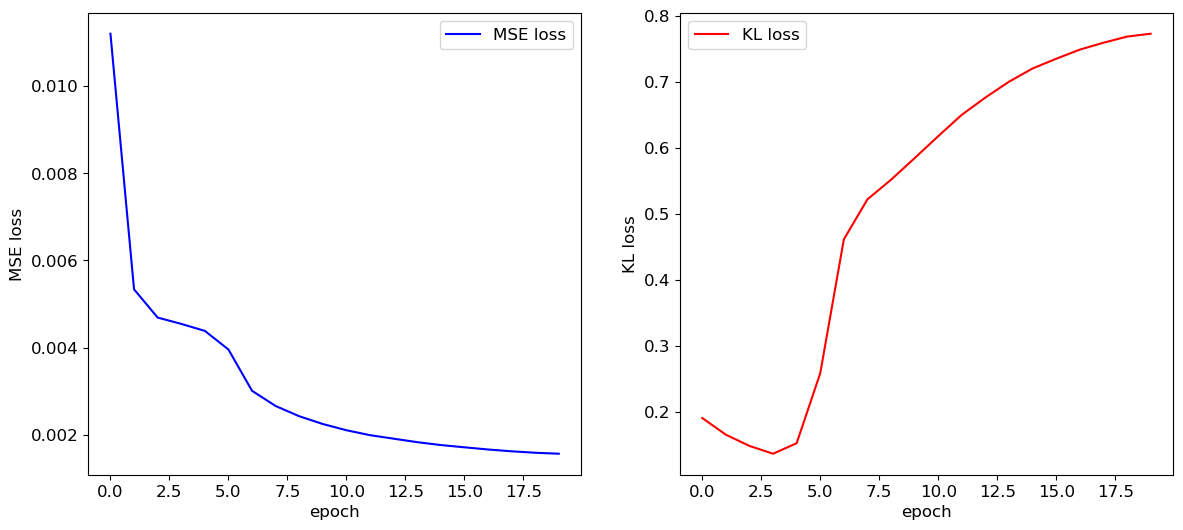

In [15]:
plt.rcParams['font.size'] = 12
fig,AX=plt.subplots(1,2,figsize=(14,6))
ax=AX[0]
ax.plot(fit.history['loss'],label="MSE loss",c="b")
ax.set_xlabel('epoch')
ax.set_ylabel("MSE loss")
ax.legend()
ax=AX[1]
ax.plot(fit.history['kl_loss'],label="KL loss",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("KL loss")
ax.legend()

## Evaluate performance
We'll now use the test set to explore the latent space distribution of data and the reconstruction accuracy

In [16]:
encoded_test = np.array(vae.encoder.predict(testset_mat))
encoded_train = np.array(vae.encoder.predict(trainset_mat))

250/250 [==============================] - 4s 18ms/step


In [17]:
print(encoded_test.shape)

(3, 2000, 50)


z_mean are the first dimension, z_log_var the second (used in training), we're interested in the third dimension, which are the sampled z

In [18]:
dim1 = encoded_test[2,:,:]
print(dim1.shape)

(2000, 50)


Sampling in the latent space is reasonably gaussian as expected

In [19]:
#df = pd.DataFrame(dim1, columns=["x", "y"])
#sns.jointplot(x="x", y="y", data=df);

We can now use the data to decode

In [20]:
decoded_test = np.array(decoder.predict(encoded_test[2,:,:])).reshape(-1,30,30)
decoded_train = np.array(decoder.predict(encoded_train[2,:,:])).reshape(-1,30,30)
print(decoded_test.shape)

250/250 [==============================] - 10s 39ms/step
(2000, 30, 30)


### Check reconstruction

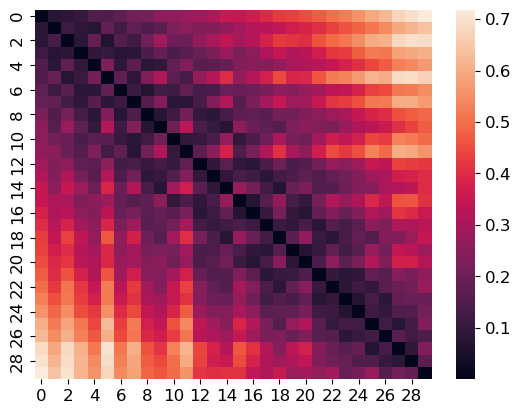

In [21]:
ind = 20
df = pd.DataFrame(decoded_test[ind])
sns.heatmap(data=df);

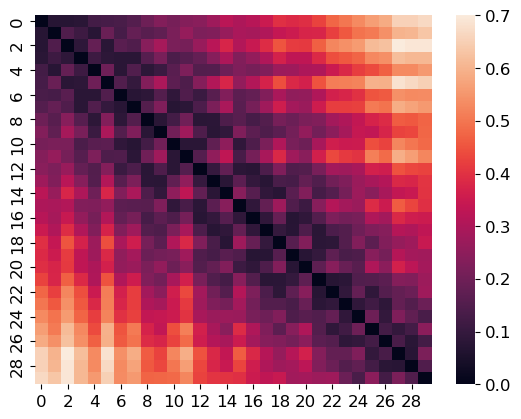

In [22]:
df2 = pd.DataFrame(testset_mat[ind])
sns.heatmap(data=df2, cmap="rocket");

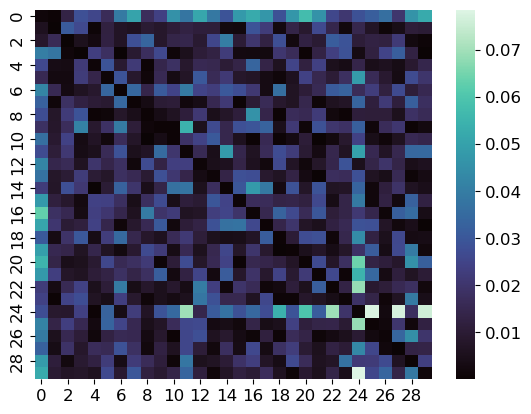

In [23]:
df3 = pd.DataFrame(abs(testset_mat[ind]-decoded_test[ind]))
sns.heatmap(data=df3, cmap="mako");

## Coordinates Reconstructor (Model 2)
The reconstructor is trained on the original distance matrices and predicts the decoded matrices

In [24]:
recmode = 2

In [25]:
if recmode == 1:
    rec_inputs = layers.Input(shape=(numpart,numpart))
    x = Flatten()(rec_inputs)
    x = layers.Dense(int(numpart**2 *4/5), activation='relu')(x)
    x = layers.Dense(int(numpart**2 *3/5), activation='relu')(x)
    x = layers.Dense(int(numpart**2 *2/5), activation='relu')(x)
    x = layers.Dense(int(numpart**2 *1/5), activation='relu')(x)
    x = layers.Dense(int(numpart*dim))(x)
    rec_outputs = Reshape((numpart, dim))(x)
    reconstruction = keras.Model(rec_inputs,rec_outputs)
    reconstruction.summary()

In [26]:
if recmode == 2:
    rec_inputs = keras.Input(shape=(numpart, numpart, 1))
    x = Conv2D(64, 3, padding='same', activation='relu')(rec_inputs)
    x = Conv2D(32, 3, padding='same', activation='relu')(x)
    x = Conv2D(1, 3, padding='same', activation='relu')(x)
    x = Flatten()(x) #Flatten
    x = layers.Dense(int(numpart**2 *2/5), activation='relu')(x)
    x = layers.Dense(int(numpart**2 *1/5), activation='relu')(x)
    x = layers.Dense(int(numpart*dim))(x)
    rec_outputs = Reshape((numpart, dim))(x)
    reconstruction = keras.Model(rec_inputs,rec_outputs)
    reconstruction.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 30, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        640       
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        18464     
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 1)         289       
                                                                 
 flatten_1 (Flatten)         (None, 900)               0         
                                                                 
 dense_1 (Dense)             (None, 360)               324360    
                                                                 
 dense_2 (Dense)             (None, 180)               64980 

In [27]:
reconstruction.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.MeanSquaredError()) #lower learning rate

In [28]:
fit=reconstruction.fit(trainset_mat, trainset_conf, epochs=30, batch_size=128, verbose=2)

Epoch 1/30
63/63 - 12s - loss: 0.0433 - 12s/epoch - 195ms/step
Epoch 2/30
63/63 - 12s - loss: 0.0052 - 12s/epoch - 193ms/step
Epoch 3/30
63/63 - 12s - loss: 0.0051 - 12s/epoch - 192ms/step
Epoch 4/30
63/63 - 12s - loss: 0.0049 - 12s/epoch - 188ms/step
Epoch 5/30
63/63 - 13s - loss: 0.0048 - 13s/epoch - 200ms/step
Epoch 6/30
63/63 - 14s - loss: 0.0046 - 14s/epoch - 223ms/step
Epoch 7/30
63/63 - 13s - loss: 0.0042 - 13s/epoch - 205ms/step
Epoch 8/30
63/63 - 12s - loss: 0.0038 - 12s/epoch - 197ms/step
Epoch 9/30
63/63 - 12s - loss: 0.0034 - 12s/epoch - 191ms/step
Epoch 10/30
63/63 - 13s - loss: 0.0030 - 13s/epoch - 207ms/step
Epoch 11/30
63/63 - 13s - loss: 0.0026 - 13s/epoch - 204ms/step
Epoch 12/30
63/63 - 14s - loss: 0.0024 - 14s/epoch - 215ms/step
Epoch 13/30
63/63 - 13s - loss: 0.0021 - 13s/epoch - 211ms/step
Epoch 14/30
63/63 - 13s - loss: 0.0019 - 13s/epoch - 209ms/step
Epoch 15/30
63/63 - 13s - loss: 0.0018 - 13s/epoch - 207ms/step
Epoch 16/30
63/63 - 13s - loss: 0.0017 - 13s/epoc

In [29]:
rec_test = np.array(reconstruction.predict(testset_mat))
rec_test_dec = np.array(reconstruction.predict(decoded_test))


63/63 [==============================] - 1s 20ms/step


### Evaluate performance
Original data is in blue, reconstructed from original distance matrix in gold

(-0.15, 1.15)

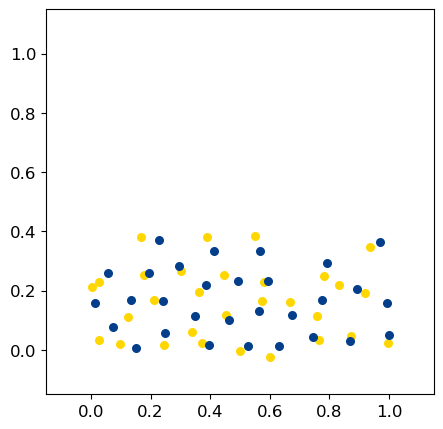

In [30]:
ind=20
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(rec_test[ind,:,0]*l, rec_test[ind,:,1]*l, s=30, c="gold")
ax.scatter(testset_conf[ind,:,0]*l, testset_conf[ind,:,1]*l, s=30, c="#023e8a")
ax.set_xlim(-0.15,1.15)
ax.set_ylim(-0.15,1.15)

Original data is in blue, recontructed from decoded matrices in red

(-0.15, 1.15)

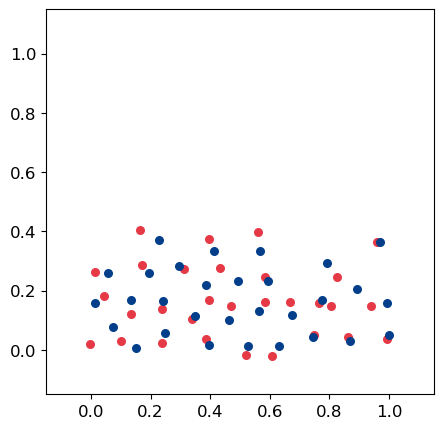

In [31]:
ind=20
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(rec_test_dec[ind,:,0]*l, rec_test_dec[ind,:,1]*l, s=30, c="#e63946")
ax.scatter(testset_conf[ind,:,0]*l, testset_conf[ind,:,1]*l, s=30, c="#023e8a")
ax.set_xlim(-0.15,1.15)
ax.set_ylim(-0.15,1.15)

MovieWriter imagemagick unavailable; using Pillow instead.


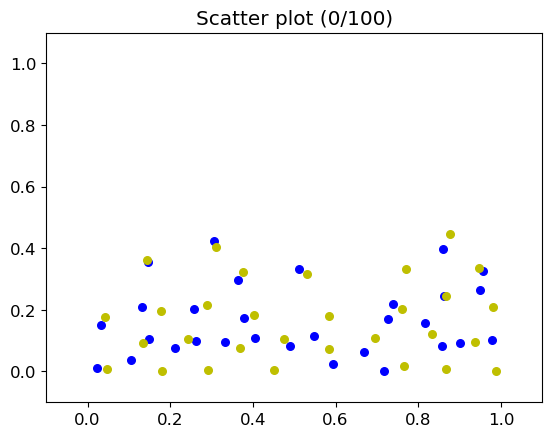

In [32]:
from matplotlib.animation import FuncAnimation

# Create the figure and axis objects
fig, ax = plt.subplots()

nframes = 100

# Define the animation function
def update(ind):
    ax.clear()
    plt.scatter(rec_test[ind,:,0]*l, rec_test[ind,:,1]*l, s=30, c="b")
    plt.scatter(testset_conf[ind,:,0]*l, testset_conf[ind,:,1]*l, s=30, c="y")
    ax.set_title(f"Scatter plot ({ind}/{nframes})")
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.1,1.1)

# Create the animation
animation = FuncAnimation(fig, update, frames=nframes, interval=400)

# Save the animation as a GIF
animation.save("conv2dist.gif", writer="imagemagick")

## Deez Labels

In [33]:
labels = [1]*len(data)

In [34]:
def label_vis(vae, data, labels):
    
    #prediction
    z_mean, _, _ = vae.encoder.predict(data)
    
    #PCA on z_mean
    A = pd.DataFrame(z_mean)
    l, V = la.eig(np.cov(A.T))
    lr = np.copy(l.real)
    n1 = np.argmax(l)
    l[n1] = 0
    n2 = np.argmax(l)
    print(lr[n1]/sum(lr), lr[n2]/sum(lr), (lr[n1]+lr[n2])/sum(lr) )

    #plot
    plt.figure(figsize=(8, 8))
    plt.scatter(z_mean[:, n1], z_mean[:, n2], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

313/313 [==============================] - 5s 15ms/step
0.048288568561897866 0.046481220378631095 0.09476978894052897


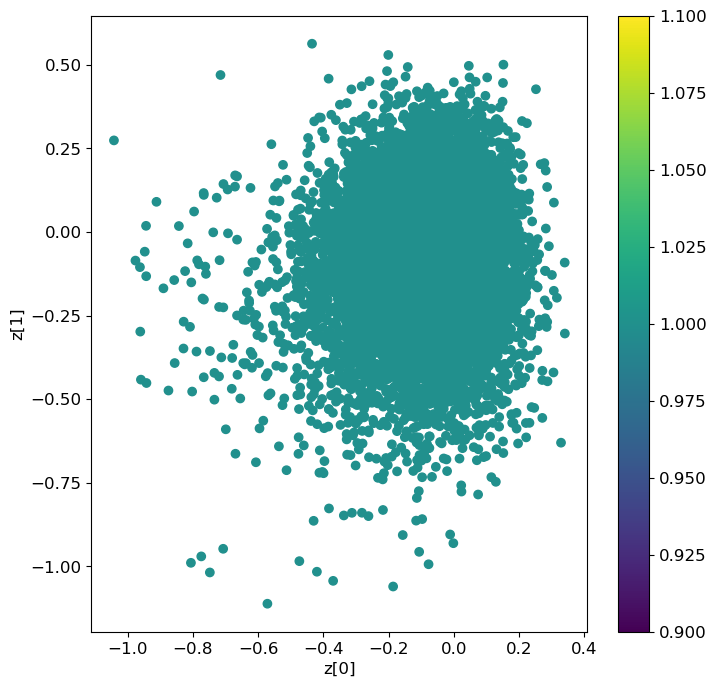

In [35]:
label_vis(vae, dm, labels)